In [126]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import warnings
warnings.simplefilter('ignore')

%matplotlib inline

In [2]:
# Load the dataset
invDf = pd.read_parquet('inventory.parquet', engine='pyarrow')
prodDf = pd.read_parquet('products.parquet', engine='pyarrow')
transDf = pd.read_parquet('transactions.parquet', engine='pyarrow')

In [3]:
def get_dataset_info(dataset):
  return dataset.info()

for info in [invDf,transDf,prodDf]:
  print(f"{get_dataset_info(info)}\n")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53315 entries, 0 to 53314
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   product_id  53315 non-null  int64
 1   color       53315 non-null  int64
 2   week        53315 non-null  int64
 3   year        53315 non-null  int64
 4   end_stock   53315 non-null  int64
dtypes: int64(5)
memory usage: 2.0 MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1219274 entries, 0 to 1219273
Data columns (total 8 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   transaction_id  1219274 non-null  int64  
 1   date            1219274 non-null  object 
 2   shop            1219274 non-null  int64  
 3   product_id      1219274 non-null  int64  
 4   quantity        1219274 non-null  int64  
 5   price           1219274 non-null  float64
 6   price_paid      1219274 non-null  float64
 7   purchase_price  1219274 non-null  f

In [4]:
# Convertig date to date time object
transDf['date'] = pd.to_datetime(transDf.date)

In [5]:
# checking for NaN values in our datasets
def checkNan(dataset):
    """A method to check for NaN values in our datasets

    Args:
        dataset (DataFrame): dataset to check for NaN values

    Returns:
        boolean: Returns boolean value if NaN values are found returns True otherwise False
    """
    return dataset.isnull().values.any()

list(map(lambda x: checkNan(x), [invDf,transDf,prodDf])) # we can see all the data present in the dataset(s) does not have any NaN values

[False, False, False]

In [6]:
def convert_to_flaot(dataset):
    """A method to downcast all the values to float64 long variables except date object.

    Args:
        dataset (DataFrame): dataset to convert the colums into float64 values

    Returns:
        DataFrame: Converted dataframe
    """
    for col in dataset.columns:
        if col != 'date' and col != 'year':
            dataset[col] = dataset[col].astype('float64')
    return dataset
    
invDf,transDf,prodDf = (map(lambda x: convert_to_flaot(x), [invDf,transDf,prodDf]))

In [7]:
# Check the values of our dataset(s)
transDf.head(3)

,transaction_id,date,shop,product_id,quantity,price,price_paid,purchase_price
0,-4.105354e+18,2018-06-27,3.467809e+18,7.525294e+18,-1.0,-61.969,-54.777,13.764
1,-8.459771e+18,2018-12-08,7.882037e+18,-1.087308e+18,1.0,105.369,105.369,21.111
2,3.140884e+18,2018-06-25,6.203040e+17,4.635203e+18,1.0,124.000,124.000,2.511


In [8]:
invDf.head(3)

,product_id,color,week,year,end_stock
0,5.013503e+18,2.836256e+17,26.0,2018,467.0
1,5.013503e+18,2.836256e+17,35.0,2018,83.0
2,5.013503e+18,2.836256e+17,37.0,2018,74.0


In [9]:
prodDf.head(3)

,product_id,color,season,group1,group2,group3,group4,supplier,price
0,-6.621881e+18,-2.483913e+18,-4.346186e+18,4.412691e+17,-7.584397e+18,-3.541297e+18,-6.020412e+18,3.171477e+18,216.845
1,1.419079e+16,4.434393e+18,3.491428e+18,4.412691e+17,-7.584397e+18,-3.541297e+18,-6.020412e+18,8.722432e+18,123.845
2,8.497159e+17,-3.276860e+18,3.491428e+18,4.412691e+17,-7.584397e+18,-3.541297e+18,-6.020412e+18,8.722432e+18,123.845


### Considering inventory dataset

In [10]:
# Check number of time series and lengths
print("Number of producuts is {}.".format(len(invDf.groupby(["product_id"]).groups.keys())))
print("Number of color is {}.".format(len(invDf.groupby(["color"]).groups.keys())))
print("Number of time series is {}.".format(len(invDf.groupby(["product_id", "color"]).groups.keys())))
print("\nLength distribution of the time series:")
print(invDf.groupby(["product_id", "color"]).size().describe())

Number of producuts is 744.
Number of color is 193.
Number of time series is 1093.

Length distribution of the time series:
count    1093.000000
mean       48.778591
std        29.186222
min         1.000000
25%        24.000000
50%        48.000000
75%        63.000000
max       104.000000
dtype: float64


In [11]:
prod_color_count_df = pd.DataFrame({'count' : invDf.groupby(["product_id", "color"] ).size()}).reset_index()

In [12]:
prod_color_count_df.head(3)

,product_id,color,count
0,-9.205752e+18,-2.120051e+18,2
1,-9.074209e+18,9.836474e+17,22
2,-9.074209e+18,2.585526e+18,22


Text(0.5, 1.0, 'Product count')

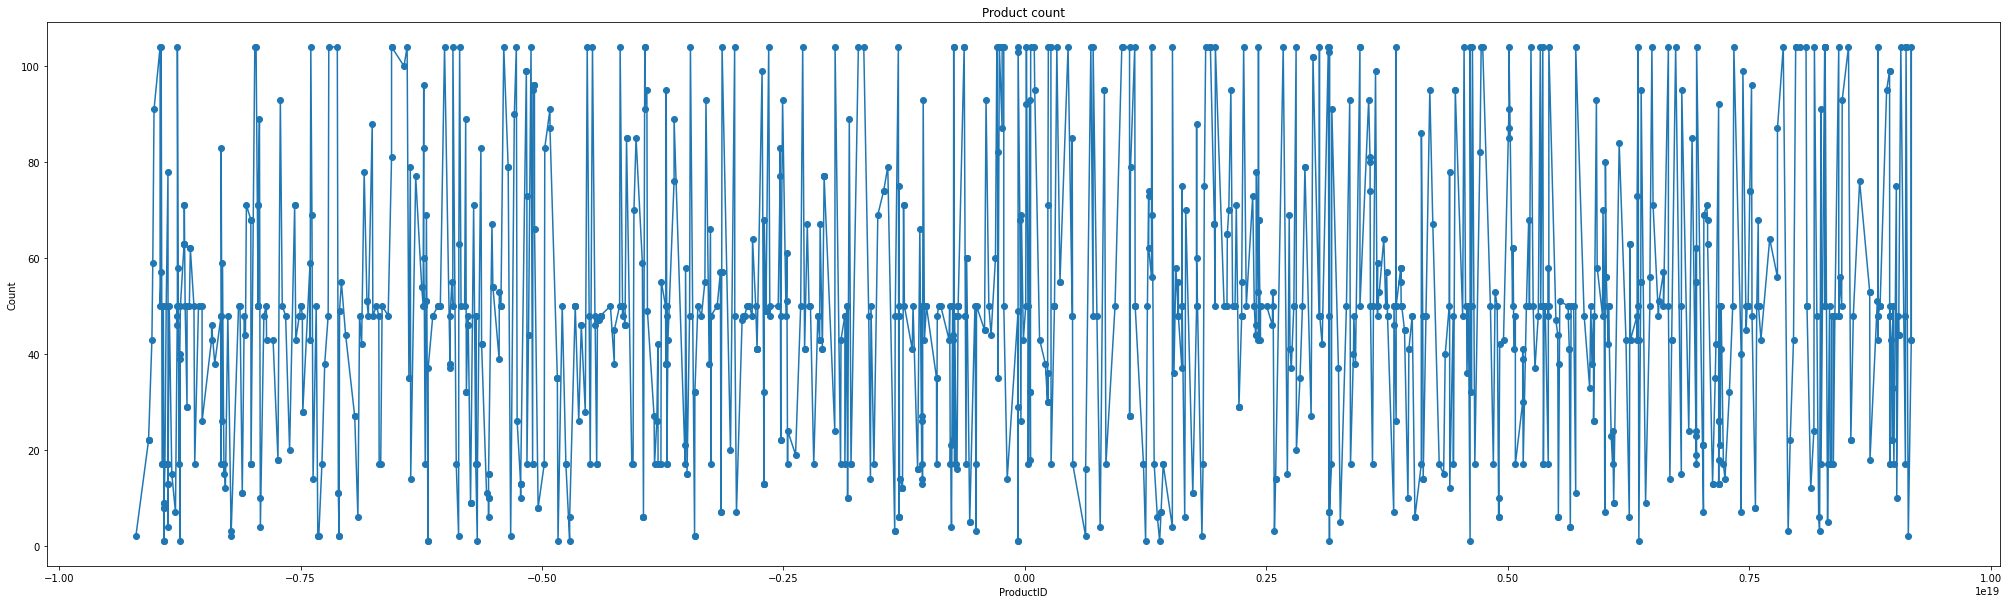

In [15]:
plt.figure(figsize=(35,10))
plt.plot(prod_color_count_df.product_id,prod_color_count_df['count'],marker='o')
plt.xlabel('ProductID')
plt.ylabel('Count')
plt.title('Product count')

In [13]:
prod_endStock_count_df = pd.DataFrame({'count' : invDf.groupby(["product_id", "year"] ).end_stock.size()}).reset_index().sort_values(by=['year'])

In [14]:
prod_endStock_count_df.head(3)

,product_id,year,count
841,6.352318e+18,2018,52
802,5.656741e+18,2018,50
432,-1.052292e+18,2018,52


In [15]:
# To fetch the count of end stock at end of the year
y1,y2 = 0,0
for idx,val in prod_endStock_count_df.iterrows():
    if val['year'] == 2018: y1+= int(val['count'])
    else: y2+= int(val['count'])

Text(0.5, 1.0, 'Total End Stock per year')

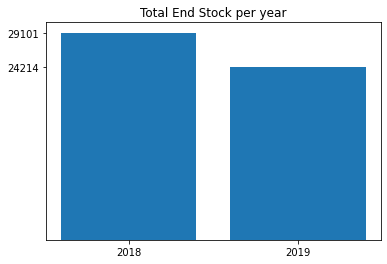

In [16]:
values = [('2018',y1),('2019',y2)]
labels, val = zip(*values)
xs = np.arange(len(labels)) 

plt.bar(xs, val)
plt.xticks(xs, labels)
plt.yticks(val)
plt.title('Total End Stock per year')

### Gather sales based on the season

- To achive this we join two datasets transaction and product datasets

- The join is based on the productID

In [17]:
prodDf

,product_id,color,season,group1,group2,group3,group4,supplier,price
0,-6.621881e+18,-2.483913e+18,-4.346186e+18,4.412691e+17,-7.584397e+18,-3.541297e+18,-6.020412e+18,3.171477e+18,216.845
1,1.419079e+16,4.434393e+18,3.491428e+18,4.412691e+17,-7.584397e+18,-3.541297e+18,-6.020412e+18,8.722432e+18,123.845
2,8.497159e+17,-3.276860e+18,3.491428e+18,4.412691e+17,-7.584397e+18,-3.541297e+18,-6.020412e+18,8.722432e+18,123.845
3,3.436431e+18,-8.748599e+18,3.491428e+18,4.412691e+17,-7.584397e+18,-3.541297e+18,-6.020412e+18,-3.148163e+18,123.845
4,3.292933e+18,6.300285e+18,-6.688484e+18,4.412691e+17,-7.584397e+18,-3.541297e+18,-6.020412e+18,8.570611e+18,123.845
...,...,...,...,...,...,...,...,...,...
3719,5.225623e+18,-2.483913e+18,-8.805101e+18,-1.649647e+18,-4.514815e+18,5.270884e+18,-5.181468e+18,-1.218806e+18,139.345
3720,4.433528e+18,1.727990e+18,-8.805101e+18,-1.649647e+18,-4.514815e+18,5.270884e+18,-5.181468e+18,7.946683e+17,154.845
3721,8.538511e+17,-5.638941e+17,-6.688484e+18,-1.649647e+18,-4.514815e+18,5.270884e+18,-5.181468e+18,5.403235e+18,139.345
3722,8.604137e+18,2.495562e+18,5.248912e+18,3.038650e+18,-8.575993e+18,3.346951e+18,-7.589239e+18,-3.148163e+18,108.345


In [18]:
prodDf.columns.values[-1] = "product_price" # Assuming the price column in the product dataset be product price

In [19]:
prodDf.head(2)

,product_id,color,season,group1,group2,group3,group4,supplier,product_price
0,-6.621881e+18,-2.483913e+18,-4.346186e+18,4.412691e+17,-7.584397e+18,-3.541297e+18,-6.020412e+18,3.171477e+18,216.845
1,1.419079e+16,4.434393e+18,3.491428e+18,4.412691e+17,-7.584397e+18,-3.541297e+18,-6.020412e+18,8.722432e+18,123.845


In [20]:
transDf

,transaction_id,date,shop,product_id,quantity,price,price_paid,purchase_price
0,-4.105354e+18,2018-06-27,3.467809e+18,7.525294e+18,-1.0,-61.969,-54.777,13.764
1,-8.459771e+18,2018-12-08,7.882037e+18,-1.087308e+18,1.0,105.369,105.369,21.111
2,3.140884e+18,2018-06-25,6.203040e+17,4.635203e+18,1.0,124.000,124.000,2.511
3,8.293949e+18,2018-05-24,5.882286e+18,3.315728e+17,1.0,37.200,30.318,16.368
4,-3.825516e+17,2019-06-29,3.467809e+18,4.394905e+18,-1.0,-74.400,-74.400,-40.796
...,...,...,...,...,...,...,...,...
1219269,8.207824e+18,2018-05-01,2.584792e+18,-5.838117e+18,1.0,15.500,13.950,46.779
1219270,5.570147e+18,2018-04-29,7.594814e+18,-7.782229e+17,1.0,15.500,15.500,21.390
1219271,3.712099e+18,2018-04-28,6.850805e+18,-7.782229e+17,1.0,15.500,10.850,21.390
1219272,5.773475e+17,2018-04-28,2.584792e+18,-5.838117e+18,1.0,15.500,15.500,46.779


In [21]:
# Merge the dataset based on the product ID
merge_dataset = pd.merge(prodDf,transDf,on='product_id')

In [22]:
merge_dataset.head(3)

,product_id,color,season,group1,group2,group3,group4,supplier,product_price,transaction_id,date,shop,quantity,price,price_paid,purchase_price
0,8.138509e+18,1.868465e+17,-3.924446e+17,1.510276e+18,-7.584397e+18,-3.541297e+18,-6.020412e+18,-9.092260e+18,154.969,-8.374639e+18,2019-06-24,6.747463e+17,1.0,154.969,154.969,40.362
1,-5.933030e+18,-1.530129e+18,6.484470e+18,1.510276e+18,-7.584397e+18,-3.541297e+18,-6.020412e+18,-2.948018e+18,123.969,-6.180864e+18,2019-06-28,-1.704741e+17,1.0,46.500,32.550,35.681
2,-5.933030e+18,-1.530129e+18,6.484470e+18,1.510276e+18,-7.584397e+18,-3.541297e+18,-6.020412e+18,-2.948018e+18,123.969,-2.166017e+18,2019-06-28,-7.255919e+18,1.0,46.500,46.500,35.681


In [23]:
# Grouping the transaction id based on shop
trans_count_based_shop = pd.DataFrame({'count' : merge_dataset.groupby(["transaction_id",'shop'] ).shop.size()}).reset_index()

In [24]:
trans_count_based_shop

,transaction_id,shop,count
0,-9.223361e+18,3.467809e+18,2
1,-9.223341e+18,3.467809e+18,2
2,-9.223335e+18,5.557508e+18,2
3,-9.223332e+18,-2.605118e+18,4
4,-9.223301e+18,5.557508e+18,8
...,...,...,...
979763,9.223282e+18,3.467809e+18,1
979764,9.223300e+18,5.557508e+18,1
979765,9.223305e+18,5.557508e+18,3
979766,9.223308e+18,5.557508e+18,3


In [25]:
# From above dataframe we gathered the transaction count based on shop. Here we are cumulating it per shop.
tot_trans_per_shop = pd.DataFrame({'Total' : trans_count_based_shop.groupby('shop')['count'].apply(sum)}).reset_index()

In [26]:
tot_trans_per_shop

,shop,Total
0,-8.626987e+18,10503
1,-8.576863e+18,10044
2,-8.461798e+18,7925
3,-8.405650e+18,1080
4,-8.276772e+18,9151
...,...,...
115,8.110360e+18,10197
116,8.386272e+18,5450
117,8.543104e+18,3736
118,8.887709e+18,9265


In [27]:
# Since we have 120 rows of unique shop, we are encoding it with different labels
from sklearn import preprocessing
le = preprocessing.LabelEncoder() # Label encoder constructor

In [28]:
# label encoding the shop id since we dont want to display the shop id as float 64 format
tot_trans_per_shop.shop = list(le.fit_transform(tot_trans_per_shop.shop))

In [29]:
class_mapping = dict(zip(le.transform(le.classes_),le.classes_)) # a dict to keep track of all our shops

In [30]:
px.bar(tot_trans_per_shop,x="shop", y="Total",title="Total Transaction per Shop (2018-2019)")

### Shop *__number 95__* makes the best sales with *__923.778k__*

In [31]:
tot_trans_per_shop

,shop,Total
0,0,10503
1,1,10044
2,2,7925
3,3,1080
4,4,9151
...,...,...
115,115,10197
116,116,5450
117,117,3736
118,118,9265


In [32]:
# Fetching top 5 best shops
top_five_shops = pd.DataFrame.from_dict(tot_trans_per_shop.Total.nlargest(5).to_dict(),orient='index',columns=['total'])
top_five_shops['shops'] = top_five_shops.index
top_five_shops

,total,shops
95,923778,95
84,738841,84
32,68804,32
47,48540,47
14,26512,14


Text(0.5, 1.0, 'Top 5 shops sales')

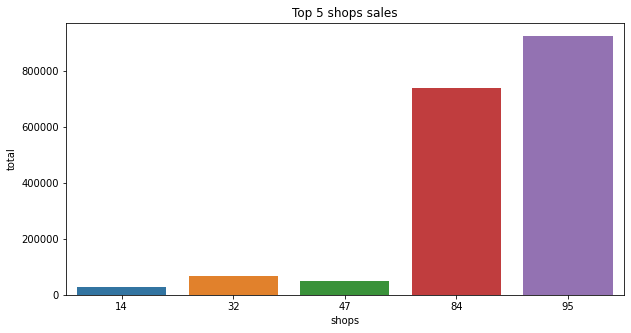

In [33]:
plt.figure(figsize=(10,5))
sns.barplot(x="shops", y="total", data=top_five_shops)
plt.title('Top 5 shops sales')

### From the above graph we can say that these shops have a good sales between 2018 and 2019.

In [34]:
merge_dataset.head(2)

,product_id,color,season,group1,group2,group3,group4,supplier,product_price,transaction_id,date,shop,quantity,price,price_paid,purchase_price
0,8.138509e+18,1.868465e+17,-3.924446e+17,1.510276e+18,-7.584397e+18,-3.541297e+18,-6.020412e+18,-9.092260e+18,154.969,-8.374639e+18,2019-06-24,6.747463e+17,1.0,154.969,154.969,40.362
1,-5.933030e+18,-1.530129e+18,6.484470e+18,1.510276e+18,-7.584397e+18,-3.541297e+18,-6.020412e+18,-2.948018e+18,123.969,-6.180864e+18,2019-06-28,-1.704741e+17,1.0,46.500,32.550,35.681


In [35]:
merge_dataset.product_id.nunique() # To fetch the number of unique products in our merged dataset

488

In [103]:
# Grouping the dataset based on shop and product id.
# First it groups based on the shop and for each shop fetches the product id count
merge_dataset.groupby(['shop','product_id'] ).product_id.count()

shop           product_id   
-8.626987e+18  -9.074209e+18    120
               -9.017388e+18     10
               -8.954581e+18     12
               -8.943598e+18      4
               -8.872920e+18     22
                               ... 
 9.187231e+18   8.984835e+18     12
                8.990690e+18      8
                9.024998e+18     24
                9.048865e+18    108
                9.179841e+18      6
Name: product_id, Length: 33652, dtype: int64

### Yet to fetch the top products based on shops 

In [43]:
merge_dataset.groupby(['shop','product_id'], sort=True).product_id.count()

shop           product_id   
-8.626987e+18  -9.074209e+18    120
               -9.017388e+18     10
               -8.954581e+18     12
               -8.943598e+18      4
               -8.872920e+18     22
                               ... 
 9.187231e+18   8.984835e+18     12
                8.990690e+18      8
                9.024998e+18     24
                9.048865e+18    108
                9.179841e+18      6
Name: product_id, Length: 33652, dtype: int64

In [36]:
# Fetching top product based on the shop with their total count of sales
top_shop_with_prod = pd.DataFrame({'Total' : merge_dataset.groupby(['shop','product_id'] ).product_id.count()}).reset_index()

In [37]:
top_shop_with_prod

,shop,product_id,Total
0,-8.626987e+18,-9.074209e+18,120
1,-8.626987e+18,-9.017388e+18,10
2,-8.626987e+18,-8.954581e+18,12
3,-8.626987e+18,-8.943598e+18,4
4,-8.626987e+18,-8.872920e+18,22
...,...,...,...
33647,9.187231e+18,8.984835e+18,12
33648,9.187231e+18,8.990690e+18,8
33649,9.187231e+18,9.024998e+18,24
33650,9.187231e+18,9.048865e+18,108


In [48]:
# Grouping the dataframe based on the shop and total count
topShopCount = top_shop_with_prod.loc[top_shop_with_prod.groupby('shop')['Total'].idxmax()]

In [52]:
# Grouping the dataframe based on the prodcut_id and total count
topProduct = topShopCount.loc[topShopCount.groupby('product_id')['Total'].idxmax()]
topProduct

,shop,product_id,Total
28935,6.793189e+18,-6.224672e+18,1320
15899,-8.295892e+17,-4.047785e+18,87
5208,-6.577573e+18,-2.772814e+18,216
21019,1.905008e+18,-2.078421e+18,248
27074,5.557508e+18,-1.059965e+18,72368
16678,-1.704741e+17,3.070384e+17,2988
19429,1.125481e+18,1.282826e+18,108
1518,-8.046556e+18,5.013503e+18,228
9429,-3.887731e+18,7.185386e+18,17584


In [57]:
topProduct.shop = le.fit_transform(topProduct.shop)
topProduct.product_id = le.fit_transform(topProduct.product_id)

In [60]:
topProduct

,shop,product_id,Total
28935,8,0,1320
15899,3,1,87
5208,1,2,216
21019,6,3,248
27074,7,4,72368
16678,4,5,2988
19429,5,6,108
1518,0,7,228
9429,2,8,17584


In [78]:
plt.figure(figsize=(10,5))
px.bar(topProduct,x="shop", y="product_id",color='Total',title="Top product sales for random 9 shops")

<Figure size 720x360 with 0 Axes>

### Fetching top prodcuts based on the season

In [166]:
merge_dataset.groupby(['season','product_id'] ).product_id.count()

season         product_id   
-6.760223e+18  -2.143490e+18        2
                1.396243e+18        2
                1.589666e+18       12
-6.102843e+18  -9.074209e+18    26685
               -8.833517e+18     1708
                                ...  
 6.484470e+18   7.622760e+18     2776
                8.749152e+18     8898
                8.827991e+18     2826
                8.972050e+18     3243
                9.048865e+18    27255
Name: product_id, Length: 488, dtype: int64

In [61]:
top_prod_season = pd.DataFrame({'Total' : merge_dataset.groupby(['season','product_id'] ).product_id.count()}).reset_index()

In [62]:
top_prod_season

,season,product_id,Total
0,-6.760223e+18,-2.143490e+18,2
1,-6.760223e+18,1.396243e+18,2
2,-6.760223e+18,1.589666e+18,12
3,-6.102843e+18,-9.074209e+18,26685
4,-6.102843e+18,-8.833517e+18,1708
...,...,...,...
483,6.484470e+18,7.622760e+18,2776
484,6.484470e+18,8.749152e+18,8898
485,6.484470e+18,8.827991e+18,2826
486,6.484470e+18,8.972050e+18,3243


In [64]:
# Grouping the dataframe based on the season and total count
topSeasonCount = top_prod_season.loc[top_prod_season.groupby('season')['Total'].idxmax()]

In [68]:
# Grouping the dataframe based on the product_id and total count
top_prd_per_season = topSeasonCount.loc[topSeasonCount.groupby('product_id')['Total'].idxmax()]

In [70]:
top_prd_per_season.season = le.fit_transform(top_prd_per_season.season)
top_prd_per_season.product_id = le.fit_transform(top_prd_per_season.product_id)

In [74]:
top_prd_per_season

,season,product_id,Total
81,2,0,1
233,6,1,16
324,9,2,343
429,12,3,49648
107,3,4,67592
40,1,5,200464
184,4,6,37548
2,0,7,12
376,11,8,402
317,8,9,5


In [81]:
plt.figure(figsize=(10,5))
px.bar(top_prd_per_season,x="product_id", y="season",color='Total',title="Top 9 product sales for random 13 shops based on season")

<Figure size 720x360 with 0 Axes>

### Forcecasting for top two products using Meta Prophet Algorithm

In [104]:
topProductDf = merge_dataset[merge_dataset.product_id == -6.224672154067569e+18]

In [105]:
topProductDf.head(2)

,product_id,color,season,group1,group2,group3,group4,supplier,product_price,transaction_id,date,shop,quantity,price,price_paid,purchase_price
1324459,-6.224672e+18,1.925120e+18,-3.924446e+17,5.864544e+18,-9.410782e+17,-3.541297e+18,-6.020412e+18,-2.617516e+18,77.469,2.472018e+18,2018-05-21,-6.005759e+18,-1.0,-61.969,-61.969,-21.824
1324460,-6.224672e+18,1.925120e+18,-3.924446e+17,5.864544e+18,-9.410782e+17,-3.541297e+18,-6.020412e+18,-2.617516e+18,77.469,4.229118e+18,2018-05-22,-6.111851e+18,-1.0,-61.969,-61.969,-21.824


In [116]:
def fetchUnique(dataset):
    """_summary_

    Args:
        dataset (_type_): _description_

    Returns:
        _type_: _description_
    """
    for cols in dataset.columns:
        if dataset[cols].nunique() == 1 and cols != 'product_id':
            dataset.drop(cols,inplace=True,axis=1)
    return dataset

In [127]:
topProductDf = fetchUnique(topProductDf)

In [128]:
topProductDf

,product_id,color,transaction_id,date,shop,quantity,price,price_paid,purchase_price
1324459,-6.224672e+18,1.925120e+18,2.472018e+18,2018-05-21,-6.005759e+18,-1.0,-61.969,-61.969,-21.824
1324460,-6.224672e+18,1.925120e+18,4.229118e+18,2018-05-22,-6.111851e+18,-1.0,-61.969,-61.969,-21.824
1324461,-6.224672e+18,1.925120e+18,8.751697e+18,2018-05-23,3.467809e+18,-1.0,-61.969,-61.969,-21.824
1324462,-6.224672e+18,1.925120e+18,9.523236e+17,2018-05-23,-2.605118e+18,-1.0,-61.969,-61.969,-21.824
1324463,-6.224672e+18,1.925120e+18,3.404149e+18,2018-05-23,9.187231e+18,-1.0,-61.969,-61.969,-21.824
...,...,...,...,...,...,...,...,...,...
1373771,-6.224672e+18,-1.530129e+18,-5.454908e+18,2018-08-21,3.467809e+18,-1.0,-77.469,-77.469,-23.560
1373772,-6.224672e+18,-1.530129e+18,9.089889e+18,2018-08-20,3.467809e+18,-1.0,-77.469,-77.469,-23.560
1373773,-6.224672e+18,-1.530129e+18,1.842575e+18,2018-08-21,3.467809e+18,-1.0,-77.469,-77.469,-23.560
1373774,-6.224672e+18,-1.530129e+18,-2.517977e+18,2018-08-27,3.467809e+18,-1.0,-77.469,-77.469,-23.560


### Using meta's prophet algorithm for forecasting

In [136]:
from prophet import Prophet
m = Prophet()

In [137]:
# Data cration for our algorithm. This takes the date as a feature and price as target class.
df = topProductDf[['date','purchase_price']]
# renaming the columns
df.columns = ['ds','y']

In [138]:
df

,ds,y
1324459,2018-05-21,-21.824
1324460,2018-05-22,-21.824
1324461,2018-05-23,-21.824
1324462,2018-05-23,-21.824
1324463,2018-05-23,-21.824
...,...,...
1373771,2018-08-21,-23.560
1373772,2018-08-20,-23.560
1373773,2018-08-21,-23.560
1373774,2018-08-27,-23.560


In [139]:
# Fiting our model
m.fit(df)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3001.26


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       37017.5     0.0405006       304.368      0.8556      0.8556      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     182       37069.6   0.000453453       71.0613   2.838e-06       0.001      281  LS failed, Hessian reset 
     197       37074.9   0.000397875       73.3632   2.597e-06       0.001      332  LS failed, Hessian reset 
     199       37074.9   0.000362274       102.168           1           1      334   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     237         37082   0.000323854        68.551   1.739e-06       0.001      415  LS failed, Hessian reset 
     299       37093.5     0.0191767       128.377       1.671      0.4977      494   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       37104.6     0.0130601  

In [142]:
future = m.make_future_dataframe(periods=730)
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
921,2021-08-11,82.840571,-290.152167,442.825823
922,2021-08-12,83.330077,-304.400328,445.763296
923,2021-08-13,83.290235,-300.880211,436.352232
924,2021-08-14,87.814541,-290.848797,444.034871
925,2021-08-15,91.922227,-293.004126,442.796426


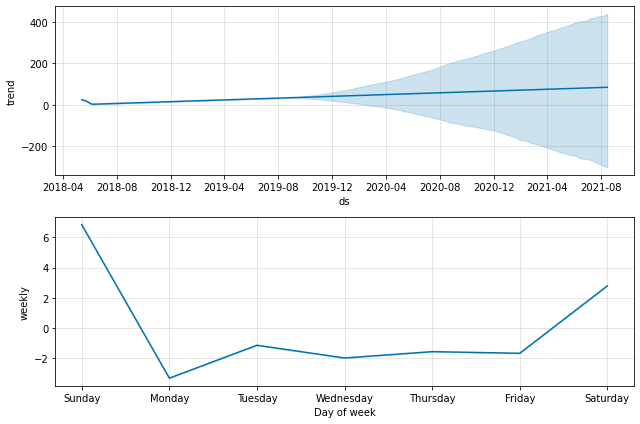

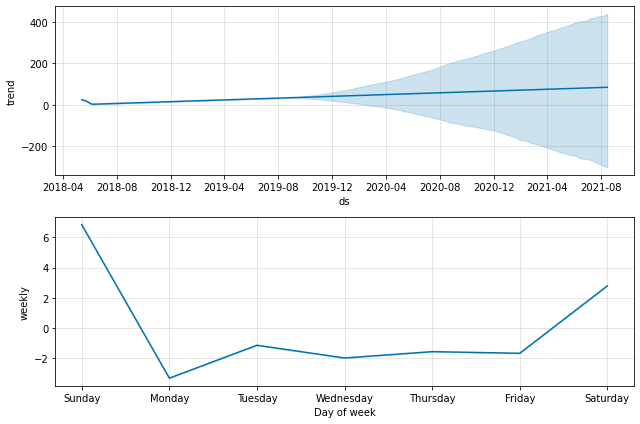

In [143]:
m.plot_components(forecast)

In [144]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)
plot_components_plotly(m, forecast)

In [145]:
nextTopProductDf = merge_dataset[merge_dataset.product_id == 5.01350333382285e+18]

In [146]:
nextTopProductDf

,product_id,color,season,group1,group2,group3,group4,supplier,product_price,transaction_id,date,shop,quantity,price,price_paid,purchase_price
4674,5.013503e+18,-1.530129e+18,-3.924446e+17,4.412691e+17,-7.584397e+18,-3.541297e+18,-6.020412e+18,6.453968e+18,108.469,-2.753859e+18,2018-05-08,5.557508e+18,-1.0,-86.769,-86.769,-25.358
4675,5.013503e+18,-1.530129e+18,-3.924446e+17,4.412691e+17,-7.584397e+18,-3.541297e+18,-6.020412e+18,6.453968e+18,108.469,-2.753859e+18,2018-05-08,5.557508e+18,-1.0,-86.769,-86.769,-25.358
4676,5.013503e+18,-1.530129e+18,-3.924446e+17,4.412691e+17,-7.584397e+18,-3.541297e+18,-6.020412e+18,6.453968e+18,108.469,-8.380393e+18,2018-05-08,5.557508e+18,-1.0,-86.769,-86.769,-25.358
4677,5.013503e+18,-1.530129e+18,-3.924446e+17,4.412691e+17,-7.584397e+18,-3.541297e+18,-6.020412e+18,6.453968e+18,108.469,1.890592e+18,2018-05-07,5.557508e+18,-1.0,-86.769,-86.769,-25.358
4678,5.013503e+18,-1.530129e+18,-3.924446e+17,4.412691e+17,-7.584397e+18,-3.541297e+18,-6.020412e+18,6.453968e+18,108.469,3.043555e+18,2018-05-10,5.557508e+18,-1.0,-86.769,-86.769,-25.358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58097,5.013503e+18,-8.189690e+18,-3.924446e+17,4.412691e+17,-7.584397e+18,-3.541297e+18,-6.020412e+18,6.453968e+18,108.469,1.044941e+18,2018-06-03,3.467809e+18,1.0,86.769,86.769,25.358
58098,5.013503e+18,-8.189690e+18,-3.924446e+17,4.412691e+17,-7.584397e+18,-3.541297e+18,-6.020412e+18,6.453968e+18,108.469,1.578094e+18,2018-05-30,5.557508e+18,1.0,86.769,86.769,25.358
58099,5.013503e+18,-8.189690e+18,-3.924446e+17,4.412691e+17,-7.584397e+18,-3.541297e+18,-6.020412e+18,6.453968e+18,108.469,5.528719e+18,2018-05-23,5.557508e+18,1.0,86.769,86.769,25.358
58100,5.013503e+18,-8.189690e+18,-3.924446e+17,4.412691e+17,-7.584397e+18,-3.541297e+18,-6.020412e+18,6.453968e+18,108.469,1.317682e+18,2018-05-31,3.467809e+18,1.0,86.769,86.769,25.358


In [147]:
nextTopProductDf = fetchUnique(nextTopProductDf)

In [148]:
nextTopProductDf

,product_id,color,transaction_id,date,shop,quantity,price,price_paid,purchase_price
4674,5.013503e+18,-1.530129e+18,-2.753859e+18,2018-05-08,5.557508e+18,-1.0,-86.769,-86.769,-25.358
4675,5.013503e+18,-1.530129e+18,-2.753859e+18,2018-05-08,5.557508e+18,-1.0,-86.769,-86.769,-25.358
4676,5.013503e+18,-1.530129e+18,-8.380393e+18,2018-05-08,5.557508e+18,-1.0,-86.769,-86.769,-25.358
4677,5.013503e+18,-1.530129e+18,1.890592e+18,2018-05-07,5.557508e+18,-1.0,-86.769,-86.769,-25.358
4678,5.013503e+18,-1.530129e+18,3.043555e+18,2018-05-10,5.557508e+18,-1.0,-86.769,-86.769,-25.358
...,...,...,...,...,...,...,...,...,...
58097,5.013503e+18,-8.189690e+18,1.044941e+18,2018-06-03,3.467809e+18,1.0,86.769,86.769,25.358
58098,5.013503e+18,-8.189690e+18,1.578094e+18,2018-05-30,5.557508e+18,1.0,86.769,86.769,25.358
58099,5.013503e+18,-8.189690e+18,5.528719e+18,2018-05-23,5.557508e+18,1.0,86.769,86.769,25.358
58100,5.013503e+18,-8.189690e+18,1.317682e+18,2018-05-31,3.467809e+18,1.0,86.769,86.769,25.358


In [158]:
m2 = Prophet()

In [150]:
# Data cration for our algorithm. This takes the date as a feature and price as target class.
df2 = nextTopProductDf[['date','purchase_price']]
# renaming the columns
df2.columns = ['ds','y']

In [154]:
df2.head()

,ds,y
4674,2018-05-08,-25.358
4675,2018-05-08,-25.358
4676,2018-05-08,-25.358
4677,2018-05-07,-25.358
4678,2018-05-10,-25.358


In [159]:
# Fiting our model
m2.fit(df2)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -17223.2
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       -6200.3    0.00205871       106.914       0.195       0.195      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199      -6156.98   0.000669571       71.3832      0.4374      0.4374      242   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     217      -6153.68    0.00259425       145.268     2.4e-05       0.001      307  LS failed, Hessian reset 
     261      -6150.45    0.00242238       144.218   2.864e-05       0.001      401  LS failed, Hessian reset 
     299      -6150.05   7.63726e-06       74.6691           1           1      449   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     309      -6150.03   8.74518e-05       86.8334   1.158e-06       0.001      498  LS failed, Hessian rese

In [160]:
future2 = m2.make_future_dataframe(periods=730)
forecast2 = m2.predict(future2)
forecast2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1001,2021-07-22,-4.717436,-164.449377,145.207764
1002,2021-07-23,-3.870217,-162.767066,139.331253
1003,2021-07-24,1.546134,-157.165749,150.876822
1004,2021-07-25,6.397261,-148.244654,153.633332
1005,2021-07-26,-7.072880,-167.435874,146.318515


In [161]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m2, forecast2)
plot_components_plotly(m2, forecast2)

In [ ]:
from prophet.plot import plot_yearly